# Striplogs Exports

In this recipe we will show how to create a `striplog` from one of Helen's images, visualize it, and save it to LAS files, and save it as PNG, or SVG format that can used in a graphics editor

First, import modules we might need

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np

import striplog
striplog.__version__


'0.6.1'

In [14]:
from striplog import Striplog, Legend
legend = Legend.default(name='nsdoe')

Define a quick function for finding files that match a given pattern:

In [5]:
import re
import os
def listdir(directory, match):
    for f in os.listdir(directory):
        if match:
            if not re.search(match, f, flags=re.IGNORECASE):
                continue
        yield os.path.join(directory, f)

Now step over the files. For each one, make a `striplog`, and add it to a dictionary. This way we can easily step over it later to process the elements or save them into files. 

Each file name has the form, `Well_start_stop.png`. Here's an example of an image, from file `M-Malagawatch-2_0_610.23.png`:

<img src="M-Malagawatch-2_0_610.23.png" width=25 />

We pass the file name into the loop, and extract the well name (*M-Malagewatch-2*), the start depth (0 m), and the end depth (610.23 m). Then we pass these to the `.from_img()` call, along with the `legend` (which it needs to assign rocks to the colours), and a 'tolerance', which tells it how flexible to be with colours.

This takes about 20 seconds to run.

In [8]:
wells = {}
directory = "../data/PNG"

for f in listdir(directory, r"[MP].+\.png"):
    name, start, stop = os.path.basename(f).strip('.png').split('_')
    
    well = Well()
    
    # Make the striplog.
    striplog = Striplog.from_img(f, float(start), float(stop), legend=legend, tolerance=35)
    
    # Add the striplog to the well.
    well.add_striplog(striplog, "lithology")
    
    wells[name] = well

In [10]:
wells.keys()

['M-Kempt-Head-84-1',
 'M-OB-62-74',
 'M-Malagawatch-1',
 'M-Maypole',
 'P-55',
 'M-P-05',
 'M-F-24',
 'P-93',
 'M-BearIsland-1',
 'M-Port-Malcolm',
 'P-103',
 'P-101',
 'P-126',
 'P-121',
 'P-120',
 'P-104',
 'P-132',
 'P-108',
 'P-129',
 'P-128',
 'M-Woodbine-Road-84-1',
 'M-Sunoco-1',
 'M-StPaul-P-91',
 'M-SYD-82',
 'M-Malagawatch-2',
 'M-SB1',
 'M-BrasDor-1',
 'M-MG-70',
 'M-BrasDor-2',
 'P-85',
 'P-86',
 'P-84',
 'M-MullRiver',
 'M-Malagawatch-10',
 'P-119',
 'P-130',
 'P-114',
 'P-117',
 'P-110',
 'P-111',
 'P-112',
 'P-113']

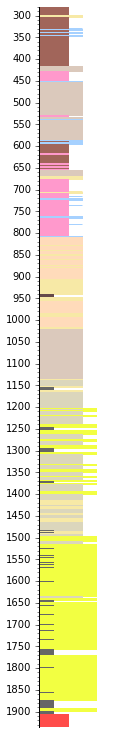

In [11]:
%matplotlib inline
wells['P-129'].striplog.lithology.plot(legend, ladder=True, interval=(10,50), aspect=10)

It's easy to form a chunk of LAS3-style text using the `striplog.to_las3()` method:

In [12]:
print wells['P-129'].striplog.lithology.to_las3()

~Lithology_Parameter
LITH .   Striplog         : Lithology source          {S}
LITHD.   MD               : Lithology depth reference {S}

~Lithology_Definition
LITHT.M                   : Lithology top depth       {F}
LITHB.M                   : Lithology base depth      {F}
LITHD.                    : Lithology description     {S}

~Lithology_Data | Lithology_Definition
  280.000,  299.986,  "Red, siltstone"                                
  299.986,  304.008,  "Grey, sandstone, vf-f"                         
  304.008,  328.016,  "Red, siltstone"                                
  328.016,  328.990,  "Limestone"                                     
  328.990,  330.007,  "Red, siltstone"                                
  330.007,  333.987,  "Limestone"                                     
  333.987,  338.983,  "Red, siltstone"                                
  338.983,  340.931,  "Limestone"                                     
  340.931,  345.927,  "Red, siltstone"                    

But anything to do with well-level operations or data happens in `Well`. So to write an entire LAS3 file, we'll need `well.striplogs_to_las3()`. However, this only works reliably if we already have an LAS file containing details like KB and so on. We don't have all this information for these wells, so we will just use our template directly and write some very simple LAS3 files.

In [13]:
from striplog import templates
import time

In [14]:
def form_las(well, striplog):
    time_now = time.strftime("%Y/%m/%d %H:%M", time.gmtime())
    result = templates.las.format(
                  prog='striplog.py',
                  date=time_now,
                  start=striplog.start,
                  stop=striplog.stop,
                  step=-999.25,
                  null=-999.25,
                  well=well,
                  uwi='',
                  lic=well,
                  apd=-999.25,
                  eref=-999.25,
                  section=striplog.to_las3(),
                  curve='')
    return result.strip() + '\n'

In [15]:
print form_las('P-129', wells['P-129'].striplog.lithology)

~Version
VERS .              3.0       :CWLS LOG ASCII STANDARD - VERSION 3.0
WRAP .               NO       :ONE LINE PER DEPTH STEP
DLM  .            COMMA       :DELIMITING CHARACTER
PROG .       striplog.py      :LAS Program name and version
CREA . 2015/03/27 13:00       :LAS Creation date {YYYY/MM/DD hh:mm}

~Well
#MNEM .UNIT  DATA             DESCRIPTION
#---- ------ --------------   -----------------------------
STRT .M       280.000         :START DEPTH
STOP .M      1935.000         :STOP DEPTH
STEP .M      -999.2500        :STEP
NULL .       -999.2500        :NULL VALUE

WELL .       P-129                 :WELL
FLD  .       UNDEFINED             :FIELD
CTRY .       CA                    :COUNTRY

PROV .       NOVA SCOTIA           :PROVINCE
UWI  .                             :UNIQUE WELL ID
LIC  .       P-129                 :LICENSE NUMBER

~Parameter
#MNEM .UNIT  VALUE            DESCRIPTION
#---- ------ --------------   -----------------------------

#Required parameters
RUN

We'll use a small function for writing files. This way we can ensure that the filenames have some structure and match the file contents, and that we don't clobber things we don't want to clobber. 

In [16]:
def write_las(data, path, suffix=None, overwrite=False):
    if not suffix:
        suffix = time.strftime("%Y%m%d-%H%M%S", time.gmtime())
    
    w = re.findall(r'\nWELL \.(.+?)\:WELL', data)[0].strip()
    file_name = re.sub(r' ', r'_', w) + '_{0}.las'.format(suffix)
    
    full_path = os.path.join(path, file_name)
    
    if (not os.path.isfile(full_path)) or overwrite:
        with open(full_path, 'w') as f:
            f.write(data)
    else:
        print w, "... file exists, not overwritten"

Now we can write a loop to go over the `well` objects in our dictionary, saving each one's striplog *lithology* to an LAS file in turn:

In [17]:
path = "../data/LAS"
for name, well in wells.items():
    data = form_las(name, well.striplog.lithology)
    write_las(data, path, suffix='striplog_from_image')

In [19]:
ls -l ../data/LAS/*striplog_from_image.las

-rw-r--r--@ 1 matt  staff   2784 27 Mar 10:00 ../data/LAS/M-BearIsland-1_striplog_from_image.las
-rw-r--r--@ 1 matt  staff   2707 27 Mar 10:00 ../data/LAS/M-BrasDor-1_striplog_from_image.las
-rw-r--r--@ 1 matt  staff   4269 27 Mar 10:00 ../data/LAS/M-BrasDor-2_striplog_from_image.las
-rw-r--r--@ 1 matt  staff  13576 27 Mar 10:00 ../data/LAS/M-F-24_striplog_from_image.las
-rw-r--r--@ 1 matt  staff  10944 27 Mar 10:00 ../data/LAS/M-Kempt-Head-84-1_striplog_from_image.las
-rw-r--r--@ 1 matt  staff   3559 27 Mar 10:00 ../data/LAS/M-MG-70_striplog_from_image.las
-rw-r--r--@ 1 matt  staff  10944 27 Mar 10:00 ../data/LAS/M-Malagawatch-10_striplog_from_image.las
-rw-r--r--@ 1 matt  staff   9876 27 Mar 10:00 ../data/LAS/M-Malagawatch-1_striplog_from_image.las
-rw-r--r--@ 1 matt  staff   6755 27 Mar 10:00 ../data/LAS/M-Malagawatch-2_striplog_from_image.las
-rw-r--r--@ 1 matt  staff   2707 27 Mar 10:00 ../data/LAS/M-Maypole_striplog_from_image.las
-rw-r--r--@ 1 matt  staff  20038 27 Mar 10:00 ../